In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from skimage.color import rgb2gray
from pathlib import Path

In [26]:
BASE_PATH = "/home/mohammed/Downloads/"

In [27]:
df_train = pd.read_csv('/home/mohammed/Downloads/data/nyu2_train.csv', names=['image', 'label'])
df_test = pd.read_csv('/home/mohammed/Downloads/data/nyu2_test.csv', names=['image', 'label'])

In [28]:
class SklearnDataGenerator:
    def __init__(self, data, num_samples, gray=True, dim=(128, 128), n_channels=3):
        """
        Initialization
        """
        self.data = data[:num_samples]
        self.images = data["image"][:num_samples]
        self.depth = data["label"][:num_samples]
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.gray = gray

    def _read_image(self, image_path):
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.dim)
            return image
        except Exception as e:
            print(f"Error: {e}")
            print(f"IMAGE: {image_path}")

    def _read_depth(self, depth_path):
        try:
            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
            depth = cv2.resize(depth, self.dim)
            depth = depth.reshape(-1)
            return depth
        except Exception as e:
            print(f"Error: {e}")
            print(f"DEPTH: {depth_path}")

    def _flatten_normalize(self, array):
        return array.reshape(-1) / 255.

    def __call__(self):
        """Load input and target images."""
        images_data = []
        depths_data = []

        for _, path in self.data.iterrows():
            image_path = BASE_PATH + path["image"]
            depth_path = BASE_PATH + path["label"]

            image = self._read_image(image_path)
            depth = self._read_depth(depth_path)
            depth = self._flatten_normalize(depth)

            if self.gray:
                gray_channel = self._flatten_normalize(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
                images_data.append(gray_channel)
            else:
                red_channel = self._flatten_normalize(image[:, :, 0])
                green_channel = self._flatten_normalize(image[:, :, 1])
                blue_channel = self._flatten_normalize(image[:, :, 2])
                images_data.append(np.stack([red_channel, green_channel, blue_channel], axis=-1).reshape(-1))

            depths_data.append(depth)

        # Convert lists to numpy arrays
        images_array = np.array(images_data)
        depths_array = np.array(depths_data)

        # For grayscale or single-channel color, ensure the array is 2D (N samples, M columns)
        if self.gray or self.n_channels == 1:
            images_array = images_array.reshape(-1, self.dim[0] * self.dim[1])
        else:  # For RGB, combine channels into a single row per sample
            images_array = images_array.reshape(-1, self.dim[0] * self.dim[1] * self.n_channels)

        # Depth array is always 2D (N samples, M columns)
        depths_array = depths_array.reshape(-1, self.dim[0] * self.dim[1])

        return images_array, depths_array


In [29]:
sklearn_data = SklearnDataGenerator(df_train, num_samples=4000, gray=True)

In [30]:
X, y = sklearn_data()

In [31]:
print(f"features shape example: {X.shape}")
print(f"target shape example: {y.shape}")

features shape example: (4000, 16384)
target shape example: (4000, 16384)


#### Sanity check
    Taking one image represented as array, reverting it and plotting. 

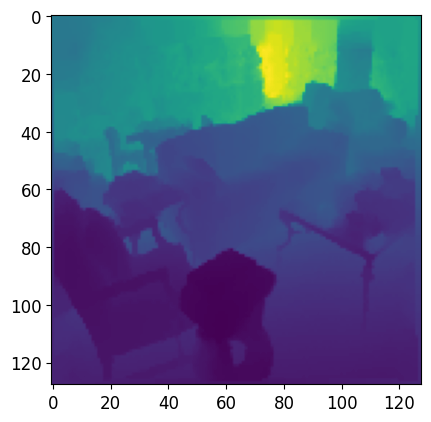

In [32]:
y_reverted = y[0].reshape(128,128)* 255
plt.imshow(y_reverted)

### Splitting dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### Dim reduction (PCA)

#### Features dim reduction

In [34]:
variance_level = 0.90
pca_x = PCA(n_components=variance_level)
# to prevent information leakage PCA is fit on train only
pca_x.fit(X_train)
X_train_trans = pca_x.transform(X_train)
X_test_trans = pca_x.transform(X_test)

In [35]:
X_train_trans.shape

(3200, 296)

In [36]:
X_test_trans.shape

(800, 296)

In [37]:
from sklearn.decomposition import IncrementalPCA

batches = 100
inc_pca = IncrementalPCA()
for x_batch in  np.array_split(X_train,batches):
    inc_pca.partial_fit(x_batch)

X_reduced = inc_pca.transform(X_train)
    

#### Target dim reduction

In [38]:
pca_y = PCA(n_components=0.95)
pca_y.fit(y_train)
y_train_trans = pca_y.transform(y_train)
y_test_trans = pca_y.transform(y_test)

In [39]:
y_train_trans.shape

(3200, 37)

In [40]:
y_test_trans.shape

(800, 37)

#### Train model and assess

In [41]:
model = RandomForestRegressor()
model.fit(X_train_trans, y_train_trans)

RandomForestRegressor()

In [42]:
score = model.score(X_test_trans, y_test_trans)
print("Score R**2 (determination)", score)

Score R**2 (determination) 0.6269630851517786


#### Visualising and comparing

In [43]:
# get prediction for one input image
y_pred = model.predict(X_test_trans[0].reshape(1, -1))

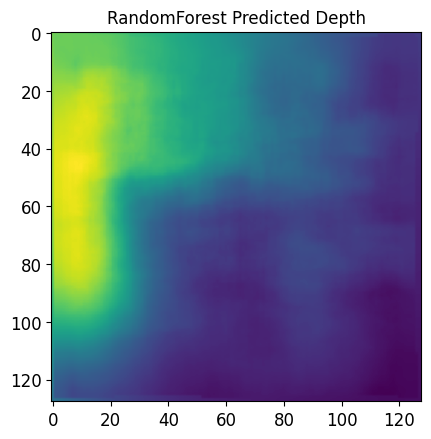

In [44]:
# inverting dim reduction, ouput size will be 256*256 = 65_536
y_test_pred_ivert_0 = pca_y.inverse_transform(y_pred)
# reshape and plot the predicted depth
plt.imshow(y_test_pred_ivert_0.reshape(128,128)*255)
plt.title("RandomForest Predicted Depth")
plt.show()

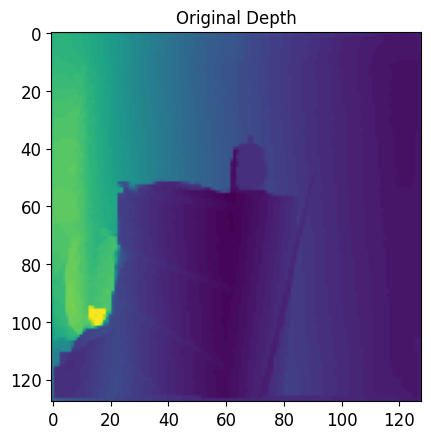

In [45]:
# plot original depth image before dim reduction (pca)
plt.imshow(y_test[0].reshape(128,128)*255)
plt.title("Original Depth")
plt.show()

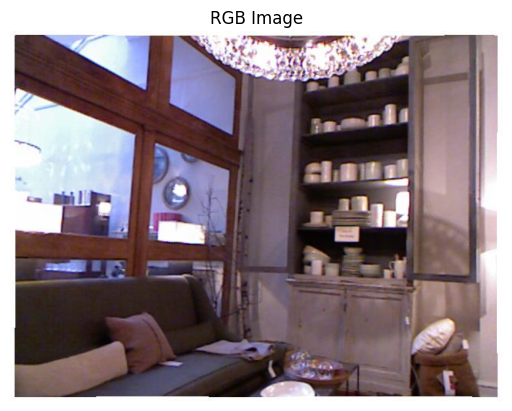

In [46]:
# Optionally, show the RGB image
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")
plt.show()